#  <font color=orange>The Simplified - Sequential Minimal Optimization (SMO) Algorithm</font> - <font color=black>Support Vector Machines</font>

## <font color=magenta>Stanford CS229</font> - <font color=black>Andrew Ng</font>

<img src="../assets/images/cs229-my-svm-notes-images/SVM.jpg">

## Introduction

This notebook implements the Simplified - SMO algorithm of Support Vector Machines. It performs <font color=blue>binary classification</font> on a generated dataset consisting of two gaussian distributed clusters of points in a 2-dimensional space. The support vectors are visually shown forming a boundary between the two clusters of points. The prediction accuracy for a learning dataset of 100 points is <font color=blue>98-100%</font>.

Resources:
- [The Simplified - Sequential Minimal Optimization (SMO) Algorithm](http://cs229.stanford.edu/materials/smo.pdf)
- [Stanford CS229 Course Notes on SVM](http://cs229.stanford.edu/summer2020/cs229-notes3.pdf)
- [Original Publication: Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines - John Platt](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

The Simplified - SMO algorithm differs from the original SMO algorithm by <font color=magenta>John Platt</font> only in the _choice of the data point 'j', given a chosen data point 'i'_ while performing gradient descent on a pair of points at a time.

Towards the end, I have included a <font color=blue>sidebar</font> on the <font color=magenta>Primal to Dual Problem</font>. 

## Taxonomy

SVM is not probabilistic. SVM takes a <font color=blue>geometric</font> approach to classification. It is a <font color=blue>discriminative</font> classifier. It is a <font color=blue>binary</font> classification algorithm. The classifier finds a <font color=blue>linear</font> hyperplane separating the two classes of data points. It is <font color=blue>parametric</font>, with weights and a bias for the features, and lagrange multipliers for the constraints.

Multi-class SVM can be developed using a one-vs-one or a one-vs-all approach.

In summary, a SVM classifier is:
- Non-Probabilistic, Geometric
- Discriminative
- Binary
- Linear
- Parametric

<img src="../assets/images/cs229-my-svm-notes-images/taxonomy-svm.png">

## Imports

In [1]:
import numpy as np #arrays for data points
from numpy.random import normal, randint #gaussian distributed data points
from numpy import dot #vector dot product for the linear kernel
import pandas as pd #create dataframe from data points, for plotting using sns
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting
%matplotlib inline

## X_m, Y

### Data Configuration

In [2]:
M = 100 #number of data points
n_features = 2 #number of dimensions
cols = ['X1', 'X2', 'Y'] #column names of the dataframe
K = 2 #number of classes
loc_scale = [(5, 1), (8, 1)] #mean and std of data points belonging to each class

### Generate Data
Gaussian clusters in 2D numpy arrays

In [3]:
def generate_X_m_and_Y(M, K, n_features, loc_scale):
    #X_m, Y
    X_m = np.empty((K, (int)(M/2), n_features), dtype=float) #initialize data points
    Y = np.empty((K, (int)(M/2)), dtype=int) #initialize the class labels
    for k in range(K): #for each class, generate data points #create data points for each class
        #create data points for class k using gaussian (normal) distribution
        X_m[k] = normal(loc=loc_scale[k][0], scale=loc_scale[k][1], size=((int)(M/2), n_features))
        #create labels (-1, +1) for class k (0, 1).
        #trick: for k=0, label is -1+2*0=-1; for k=1, label is -1+2*1=1
        Y[k] = np.full(((int)(M/2)), -1 + 2*k, dtype=int)
    X_m = X_m.reshape(M, K) #collapse the class axis
    Y = Y.reshape(M) #collapse the class axis
    X_m.shape, Y.shape #print shapes
    
    return X_m, Y

X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale)

### X_m, Y in DataFrame

In [4]:
def create_df_from_array(X_m, Y, n_features, cols):
    #create series from each column of X_m, and a series from Y
    l_series = [] #list of series, one for each column
    for feat in range(n_features): #create series from each column of X_m
        l_series.append(pd.Series(X_m[:, feat])) #create series from a column of X_m
    l_series.append(pd.Series(Y[:])) #create series from Y

    frame = {col : series for col, series in zip(cols, l_series)} #map of column names to series
    df = pd.DataFrame(frame) #create dataframe from map

    return df

df = create_df_from_array(X_m, Y, n_features, cols)
df.sample(n = 10)

,X1,X2,Y
40,5.211933,3.162270,-1
96,7.682917,9.953946,1
22,2.870566,5.851050,-1
43,3.325478,3.798079,-1
59,7.752266,8.119911,1
52,7.489131,8.838146,1
2,4.896474,4.321929,-1
57,10.056611,7.791627,1
84,8.746390,7.573401,1
32,5.165944,5.219445,-1


<AxesSubplot:xlabel='X1', ylabel='X2'>

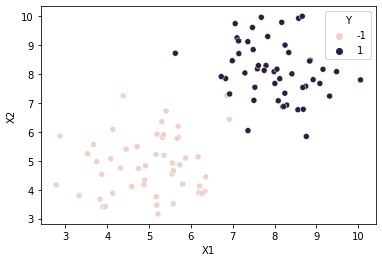

In [5]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[0], y=cols[1], hue=cols[2], data=df)

## Model

### Model Configuration

In [6]:
#cost to pay if functional margin is < 1
C = 0.6 #regularization parameter

#tolerance for meeting the KKT conditions that are used to check for convergence
tol = 0.001 #tolerance

#number of iterations to perform after the alphas have converged
max_passes = 5

### Model Prediction Data Structures

Note that alphas and bias are created here for testing the functions that follow. They will be created fresh inside the SMO algorithm.

In [7]:
#estimated lagrangian Multipliers
#most of the alphas will be close to zero, except for alphas of data points that are support vectors
alphas = np.zeros((M), dtype=float) #one multiplier for each data point

#bias of the dual problem
#in the primal problem, we have both w (weights) and b (bias).
#in the dual problem, w is replaced with alpha, but b remains.
bias = 0.0

### Linear Kernel

In [8]:
'''linear kernel : compute the dot product of the 2 vectors
    
    returns:
        (float) the dot product of the 2 vectors
        
    parameters:
        X1: the first vector
        X2: the second vector
'''
def k_lin(X1, X2):
    return dot(X1, X2)

### Predict (eq 2)

<a href="https://www.codecogs.com/eqnedit.php?latex=f\left&space;(&space;x&space;\right&space;)=&space;\sum_{i=1}^{m}\alpha&space;_{i}y^{\left&space;(&space;i&space;\right&space;)}\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},&space;x&space;\right&space;\rangle&space;&plus;&space;b" target="_blank"><img src="https://latex.codecogs.com/gif.latex?f\left&space;(&space;x&space;\right&space;)=&space;\sum_{i=1}^{m}\alpha&space;_{i}y^{\left&space;(&space;i&space;\right&space;)}\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},&space;x&space;\right&space;\rangle&space;&plus;&space;b" title="f\left ( x \right )= \sum_{i=1}^{m}\alpha _{i}y^{\left ( i \right )}\left \langle x^{\left ( i \right )}, x \right \rangle + b" /></a>

In [9]:
'''predict the label given the input, training data, and learnt parameters alphas and bias.
    this is equivalent to WX + b, but using alphas instead of W.
'''
def fx(X, X_m, Y, alphas, bias, knl = k_lin):
    pred = 0.0
    for i, Xi in enumerate(X_m):
        pred += alphas[i] * Y[i] * knl(Xi, X)
    
    return pred + bias

fx(X_m[0], X_m, Y, alphas, bias)

0.0

### Error for a data point (eq 13)

<a href="https://www.codecogs.com/eqnedit.php?latex=E_{k}=f\left&space;(&space;x^{\left&space;(&space;k&space;\right&space;)}&space;\right&space;)-y^{\left&space;(&space;k&space;\right&space;)}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?E_{k}=f\left&space;(&space;x^{\left&space;(&space;k&space;\right&space;)}&space;\right&space;)-y^{\left&space;(&space;k&space;\right&space;)}" title="E_{k}=f\left ( x^{\left ( k \right )} \right )-y^{\left ( k \right )}" /></a>

In [10]:
'''error between the SVM output and the true label
'''
def Err(X, y, X_m, Y, alphas, bias, knl = k_lin):
    #predict the label
    y_pred = fx(X, X_m, Y, alphas, bias, knl)
    
    return y_pred - (float)(y)

Err(X_m[0], Y[0], X_m, Y, alphas, bias)

1.0

### KKT Dual Complementarity Conditions (eq 6-8)

<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{i}=&space;0\Rightarrow&space;y^{\left&space;(&space;i&space;\right&space;)}\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&plus;b&space;\right&space;)\geq&space;1" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{i}=&space;0\Rightarrow&space;y^{\left&space;(&space;i&space;\right&space;)}\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&plus;b&space;\right&space;)\geq&space;1" title="\alpha _{i}= 0\Rightarrow y^{\left ( i \right )}\left ( w^{T}x^{\left ( i \right )}+b \right )\geq 1" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{i}=C\Rightarrow&space;y\left&space;(&space;i&space;\right&space;)\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&space;&plus;b\right&space;)\leq&space;1" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{i}=C\Rightarrow&space;y\left&space;(&space;i&space;\right&space;)\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&space;&plus;b\right&space;)\leq&space;1" title="\alpha _{i}=C\Rightarrow y\left ( i \right )\left ( w^{T}x^{\left ( i \right )} +b\right )\leq 1" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=0<&space;\alpha&space;_{i}<&space;C\Rightarrow&space;y\left&space;(&space;i&space;\right&space;)\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&space;&plus;b\right&space;)=&space;1" target="_blank"><img src="https://latex.codecogs.com/gif.latex?0<&space;\alpha&space;_{i}<&space;C\Rightarrow&space;y\left&space;(&space;i&space;\right&space;)\left&space;(&space;w^{T}x^{\left&space;(&space;i&space;\right&space;)}&space;&plus;b\right&space;)=&space;1" title="0< \alpha _{i}< C\Rightarrow y\left ( i \right )\left ( w^{T}x^{\left ( i \right )} +b\right )= 1" /></a>

The above equations translate into the following pseudo-code:
<img src="../assets/images/cs229-my-svm-notes-images/kkt-cond.png">

In [11]:
'''Karush-Kuhn-Tucker conditions
'''
def kkt(y, err, alpha):
    if ((y * err < -tol) and (alpha < C)) or \
    ((y * err > tol) and (alpha > 0)):
        return True
    
    return False

err = Err(X_m[0], Y[0], X_m, Y, alphas, bias)
kkt(Y[0], err, alphas[0])

True

### L and H - boundary constraints on alphas (eq 10-11)

<a href="https://www.codecogs.com/eqnedit.php?latex=y^{\left&space;(&space;i&space;\right&space;)}\neq&space;y^{j}&space;\Rightarrow&space;L&space;=&space;max(0,&space;\alpha&space;_{j}-\alpha&space;_{i}),&space;H&space;=&space;min(C,&space;C&plus;\alpha&space;_{j}-\alpha&space;_{i}))" target="_blank"><img src="https://latex.codecogs.com/gif.latex?y^{\left&space;(&space;i&space;\right&space;)}\neq&space;y^{j}&space;\Rightarrow&space;L&space;=&space;max(0,&space;\alpha&space;_{j}-\alpha&space;_{i}),&space;H&space;=&space;min(C,&space;C&plus;\alpha&space;_{j}-\alpha&space;_{i}))" title="y^{\left ( i \right )}\neq y^{j} \Rightarrow L = max(0, \alpha _{j}-\alpha _{i}), H = min(C, C+\alpha _{j}-\alpha _{i}))" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=y^{\left&space;(&space;i&space;\right&space;)}=&space;y^{j}&space;\Rightarrow&space;L&space;=&space;max(0,&space;\alpha&space;_{i}&plus;\alpha&space;_{j}-C),&space;H&space;=&space;min(C,&space;\alpha&space;_{i}&plus;\alpha&space;_{j}))" target="_blank"><img src="https://latex.codecogs.com/gif.latex?y^{\left&space;(&space;i&space;\right&space;)}=&space;y^{j}&space;\Rightarrow&space;L&space;=&space;max(0,&space;\alpha&space;_{i}&plus;\alpha&space;_{j}-C),&space;H&space;=&space;min(C,&space;\alpha&space;_{i}&plus;\alpha&space;_{j}))" title="y^{\left ( i \right )}= y^{j} \Rightarrow L = max(0, \alpha _{i}+\alpha _{j}-C), H = min(C, \alpha _{i}+\alpha _{j}))" /></a>

In [12]:
def LH(yi, yj, ai, aj):
    if yi != yj:
        L, H = max(0, aj-ai), min(C, C+aj-ai)
    else:
        L, H = max(0, ai+aj-C), min(C, ai+aj)
        
    #if(L > H):
        #print('L IS GREATER THAN H: L=', L, ' H=', H, ' yi=', yi, ' yj=', yj, ' ai=', ai, ' aj=', aj)
        
    return L, H

LH(Y[0], Y[1], alphas[0], alphas[1])

(0, 0.0)

### n - denominator when calculating optimal alpha_j (eq 14)

<a href="https://www.codecogs.com/eqnedit.php?latex=\eta&space;=2\left&space;(&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;)-\left&space;(&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;i&space;\right&space;)}&space;\right&space;)-\left&space;(&space;x^{\left&space;(&space;j&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\eta&space;=2\left&space;(&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;)-\left&space;(&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;i&space;\right&space;)}&space;\right&space;)-\left&space;(&space;x^{\left&space;(&space;j&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;)" title="\eta =2\left ( x^{\left ( i \right )},x^{\left ( j \right )} \right )-\left ( x^{\left ( i \right )},x^{\left ( i \right )} \right )-\left ( x^{\left ( j \right )},x^{\left ( j \right )} \right )" /></a>

In [13]:
'''denominator when calculating optimal alpha_j
'''
def n_den(Xi, Xj, knl = k_lin):
    return 2 * knl(Xi, Xj) - knl(Xi, Xi) - knl(Xj, Xj) #TODO line 63 return (-1) *

n_den(X_m[0], X_m[1])

-1.6061731002951376

### alpha_j (eq 12)

<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{j}:=&space;\alpha&space;_{j}-\frac{y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;E_{i}-E_{j}&space;\right&space;)}{\eta&space;}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{j}:=&space;\alpha&space;_{j}-\frac{y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;E_{i}-E_{j}&space;\right&space;)}{\eta&space;}" title="\alpha _{j}:= \alpha _{j}-\frac{y^{\left ( j \right )}\left ( E_{i}-E_{j} \right )}{\eta }" /></a>

In [14]:
def alpha_j(aj, yj, err_i, err_j, n):
    return aj - ((yj * (err_i - err_j)) / n) #TODO line 65 aj + 

i, j = 0, M-1
Xi, Xj, Yi, Yj = X_m[i], X_m[j], Y[i], Y[j]
err_i = Err(Xi, Yi, X_m, Y, alphas, bias)
err_j = Err(Xj, Yj, X_m, Y, alphas, bias)
n = n_den(Xi, Xj)
aj = alpha_j(alphas[j], Yj, err_i, err_j, n)
print('Xi=', Xi, 'Yi=', Yi)
print('Xj=', Xj, 'Yj=', Yj)
print('err_i=', err_i, 'err_j=', err_j, 'n=', n, 'aj=', aj)

Xi= [2.7774898  4.15832218] Yi= -1
Xj= [6.98985299 8.45370087] Yj= 1
err_i= 1.0 err_j= -1.0 n= -36.19428180189391 aj= 0.05525734730548922


### clipped / constrained alpha_j (eq 15)

<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{j}:=\left\{\begin{matrix}&space;H&space;&&space;if\:&space;\alpha&space;_{j}&space;>&space;H&space;\\&space;\alpha&space;_{j}&space;&&space;if\:&space;L&space;\leq&space;\alpha&space;_{j}&space;\leq&space;H\\&space;L&space;&&space;if\;&space;\alpha&space;_{j}&space;<&space;L&space;\end{matrix}\right." target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{j}:=\left\{\begin{matrix}&space;H&space;&&space;if\:&space;\alpha&space;_{j}&space;>&space;H&space;\\&space;\alpha&space;_{j}&space;&&space;if\:&space;L&space;\leq&space;\alpha&space;_{j}&space;\leq&space;H\\&space;L&space;&&space;if\;&space;\alpha&space;_{j}&space;<&space;L&space;\end{matrix}\right." title="\alpha _{j}:=\left\{\begin{matrix} H & if\: \alpha _{j} > H \\ \alpha _{j} & if\: L \leq \alpha _{j} \leq H\\ L & if\; \alpha _{j} < L \end{matrix}\right." /></a>

In [15]:
def clip_alpha_j(aj, L, H):
    if aj > H:
        return H
    elif (L <= aj and aj <= H):
        return aj
    else:
        return L

i, j = 0, M-1
Xi, Xj, Yi, Yj = X_m[i], X_m[j], Y[i], Y[j]
err_i = Err(Xi, Yi, X_m, Y, alphas, bias)
err_j = Err(Xj, Yj, X_m, Y, alphas, bias)
n = n_den(Xi, Xj)
aj = alpha_j(alphas[j], Yj, err_i, err_j, n)
print('aj_old=', alphas[j], 'aj_new=', aj)
L, H = LH(Y[i], Y[j], alphas[i], aj)
aj = clip_alpha_j(aj, L, H)
print('L=', L, 'H=', H, 'aj_clipped=', aj)

aj_old= 0.0 aj_new= 0.05525734730548922
L= 0.05525734730548922 H= 0.6 aj_clipped= 0.05525734730548922


### alpha_i (eq 16)

<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{i}:=\alpha&space;_{i}&plus;y^{\left&space;(&space;i&space;\right&space;)}y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;-\alpha&space;_{j}\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{i}:=\alpha&space;_{i}&plus;y^{\left&space;(&space;i&space;\right&space;)}y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;-\alpha&space;_{j}\right&space;)" title="\alpha _{i}:=\alpha _{i}+y^{\left ( i \right )}y^{\left ( j \right )}\left ( \alpha _{j}^{\left ( old \right )} -\alpha _{j}\right )" /></a>

In [16]:
def alpha_i(ai, aj_old, aj, yi, yj):
    return ai + (yi * yj * (aj_old - aj))

i, j = 0, M-1
Xi, Xj, Yi, Yj = X_m[i], X_m[j], Y[i], Y[j]
err_i = Err(Xi, Yi, X_m, Y, alphas, bias)
err_j = Err(Xj, Yj, X_m, Y, alphas, bias)
n = n_den(Xi, Xj)
aj = alpha_j(alphas[j], Yj, err_i, err_j, n)
print('aj_old=', alphas[j], 'aj_new=', aj)
L, H = LH(Y[i], Y[j], alphas[i], aj)
aj = clip_alpha_j(aj, L, H)
print('L=', L, 'H=', H, 'aj_clipped=', aj)
ai = alpha_i(alphas[i], alphas[j], aj, Yi, Yj)
print('ai_old=', alphas[i], 'ai_new=', ai)

aj_old= 0.0 aj_new= 0.05525734730548922
L= 0.05525734730548922 H= 0.6 aj_clipped= 0.05525734730548922
ai_old= 0.0 ai_new= 0.05525734730548922


### b1, b2, b (eq 17-19)

<a href="https://www.codecogs.com/eqnedit.php?latex=b_{1}=b-E_{i}-y^{\left&space;(&space;i&space;\right&space;)}\left&space;(\alpha&space;_{i}-\alpha&space;_{i}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;i&space;\right&space;)}&space;\right&space;\rangle-y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}-\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle" target="_blank"><img src="https://latex.codecogs.com/gif.latex?b_{1}=b-E_{i}-y^{\left&space;(&space;i&space;\right&space;)}\left&space;(\alpha&space;_{i}-\alpha&space;_{i}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;i&space;\right&space;)}&space;\right&space;\rangle-y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}-\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle" title="b_{1}=b-E_{i}-y^{\left ( i \right )}\left (\alpha _{i}-\alpha _{i}^{\left ( old \right )} \right )\left \langle x^{\left ( i \right )},x^{\left ( i \right )} \right \rangle-y^{\left ( j \right )}\left ( \alpha _{j}-\alpha _{j}^{\left ( old \right )} \right )\left \langle x^{\left ( i \right )},x^{\left ( j \right )} \right \rangle" /></a>

In [17]:
def b1(Xi, Xj, Yi, Yj, ai_old, ai, aj_old, aj, b, err_i, knl = k_lin):
    return b - err_i - Yi * (ai - ai_old) * knl(Xi, Xi) - Yj * (aj - aj_old) * knl(Xi, Xj)

<a href="https://www.codecogs.com/eqnedit.php?latex=b_{2}=b-E_{j}-y^{\left&space;(&space;i&space;\right&space;)}\left&space;(\alpha&space;_{i}-\alpha&space;_{i}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle-y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}-\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;j&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle" target="_blank"><img src="https://latex.codecogs.com/gif.latex?b_{2}=b-E_{j}-y^{\left&space;(&space;i&space;\right&space;)}\left&space;(\alpha&space;_{i}-\alpha&space;_{i}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;i&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle-y^{\left&space;(&space;j&space;\right&space;)}\left&space;(&space;\alpha&space;_{j}-\alpha&space;_{j}^{\left&space;(&space;old&space;\right&space;)}&space;\right&space;)\left&space;\langle&space;x^{\left&space;(&space;j&space;\right&space;)},x^{\left&space;(&space;j&space;\right&space;)}&space;\right&space;\rangle" title="b_{2}=b-E_{j}-y^{\left ( i \right )}\left (\alpha _{i}-\alpha _{i}^{\left ( old \right )} \right )\left \langle x^{\left ( i \right )},x^{\left ( j \right )} \right \rangle-y^{\left ( j \right )}\left ( \alpha _{j}-\alpha _{j}^{\left ( old \right )} \right )\left \langle x^{\left ( j \right )},x^{\left ( j \right )} \right \rangle" /></a>

In [18]:
def b2(Xi, Xj, Yi, Yj, ai_old, ai, aj_old, aj, b, err_j, knl = k_lin):
    return b - err_j - Yi * (ai - ai_old) * knl(Xi, Xj) - Yj * (aj - aj_old) * knl(Xj, Xj)

<a href="https://www.codecogs.com/eqnedit.php?latex=b:=\left\{\begin{matrix}&space;b_{1}&space;&&space;if\;&space;0<\alpha&space;_{i}<C&space;\\&space;b_{2}&space;&&space;if\;&space;0<&space;\alpha&space;_{j}<C\\&space;\left&space;(b_{1}&plus;b_{2}&space;\right&space;)/2&space;&&space;otherwise&space;\end{matrix}\right." target="_blank"><img src="https://latex.codecogs.com/gif.latex?b:=\left\{\begin{matrix}&space;b_{1}&space;&&space;if\;&space;0<\alpha&space;_{i}<C&space;\\&space;b_{2}&space;&&space;if\;&space;0<&space;\alpha&space;_{j}<C\\&space;\left&space;(b_{1}&plus;b_{2}&space;\right&space;)/2&space;&&space;otherwise&space;\end{matrix}\right." title="b:=\left\{\begin{matrix} b_{1} & if\; 0<\alpha _{i}<C \\ b_{2} & if\; 0< \alpha _{j}<C\\ \left (b_{1}+b_{2} \right )/2 & otherwise \end{matrix}\right." /></a>

In [19]:
def b(b1, b2, ai, aj):
    if (ai > 0 and ai < C):
        return b1
    elif (aj > 0 and aj < C):
        return b2
    else:
        return (b1 + b2)/2

In [20]:
i, j = 0, M-1
Xi, Xj, Yi, Yj = X_m[i], X_m[j], Y[i], Y[j]
err_i = Err(Xi, Yi, X_m, Y, alphas, bias)
err_j = Err(Xj, Yj, X_m, Y, alphas, bias)
n = n_den(Xi, Xj)
ai_old = alphas[i]
aj_old = alphas[j]
aj = alpha_j(aj_old, Yj, err_i, err_j, n)
print('aj_old=', aj_old, 'aj_new=', aj)
L, H = LH(Y[i], Y[j], ai_old, aj)
aj = clip_alpha_j(aj, L, H)
print('L=', L, 'H=', H, 'aj_clipped=', aj)
ai = alpha_i(ai_old, aj_old, aj, Yi, Yj)
print('ai_old=', ai_old, 'ai_new=', ai)

b1_val = b1(Xi, Xj, Yi, Yj, ai_old, ai, aj_old, aj, bias, err_i)
print('b1=', b1_val)
b2_val = b2(Xi, Xj, Yi, Yj, ai_old, ai, aj_old, aj, bias, err_j)
print('b2=', b2_val)
b_val = b(b1_val, b2_val, ai, aj)
print('b=', b_val)

aj_old= 0.0 aj_new= 0.05525734730548922
L= 0.05525734730548922 H= 0.6 aj_clipped= 0.05525734730548922
ai_old= 0.0 ai_new= 0.05525734730548922
b1= -2.6334825719646275
b2= -2.6334825719646275
b= -2.6334825719646275


### select random j

In [21]:
#select a j not equal to i
def sel_rand_j(i):
    j = randint(M) #select a random number j in the range 0..M-1
    while (j==i): #while we got i as the random number, in which case j == i, we keep trying a different random number
        j = randint(M) #try a different random number
    return j #now we have a random number in the range 0..M that is not equal to i

### <font color=blue>Simplified SMO</font>

#### pseudo-code

<img src="../assets/images/cs229-my-svm-notes-images/simplified-smo.png">

#### python code

In [22]:
def simplified_smo(C, tol, max_passes, X_m, Y, knl = k_lin):
    
    #1 Initialize alphas, and beta
    
    #estimated lagrangian Multipliers
    #most of the alphas will be close to zero, except for alphas of data points that are support vectors
    a_m = np.zeros((M), dtype=float) #one multiplier for each data point

    #bias of the dual problem
    #in the primal problem, we have both w (weights) and b (bias).
    #in the dual problem, w is replaced with alpha, but b remains.
    b_val = 0.0
    
    #2 count number of passes after the alphas have converged
    passes = 0
    
    #3 while alphas are converging, and a little beyond (max_passes beyond convergence)
    while (passes < max_passes):
        #3.1 number of alphas that changed.
        #    if they are greater than zero, we reset passes to 0. (alphas have not converged yet)
        #    if they are equal to zero, we increment passes up to max_passes, allowing alphas to converge further if they can.
        num_changed_alphas = 0
        
        #3.2 loop over the dataset, trying to converge 2 alphas
        for i in range(M):
            
            #3.2.1 calculate error between predicted label and actual label for data point i
            err_i = Err(X_m[i], Y[i], X_m, Y, a_m, b_val, knl)
            
            #3.2.2 if the KKT conditions are met
            if (kkt(Y[i], err_i, a_m[i])):
                #3.2.2.1 select j != i randomly
                j = sel_rand_j(i)
                #3.2.2.2 calculate error between predicted label and actual label for data point j
                err_j = Err(X_m[j], Y[j], X_m, Y, a_m, b_val, knl)
                #3.2.2.3 save old alphas
                ai_old, aj_old = a_m[i], a_m[j]
                #3.2.2.4 compute L and H
                L, H = LH(Y[i], Y[j], a_m[i], a_m[j])
                #3.2.2.5 if L and H are the same, we try again with a different alpha_i
                if (L == H):
                    continue
                #3.2.2.6 compute the denominator n
                n = n_den(X_m[i], X_m[j], knl)
                #3.2.2.7 if n == 0, we treat this as a case where we cannot make progress on this pair of alphas
                if (n == 0):#TODO n==0 or > =0
                    continue
                #3.2.2.8 compute and clip the new value of alpha_j
                a_m[j] = alpha_j(a_m[j], Y[j], err_i, err_j, n)
                a_m[j] = clip_alpha_j(a_m[j], L, H)
                #3.2.2.9 if alpha_j has converged, move to a new set of alphas
                if abs(a_m[j] - aj_old) < pow(10, -5): #has alpha_j converged? #TODO abs
                    continue
                #3.2.2.10 determine value of alpha_i
                a_m[i] = alpha_i(ai_old, aj_old, a_m[j], Y[i], Y[j]) # ai = ai + yi*yj*(aj_old - aj)
                #3.2.2.11 compute b1 and b2
                b1_val = b1(X_m[i], X_m[j], Y[i], Y[j], ai_old, a_m[i], aj_old, a_m[j], b_val, err_i)
                b2_val = b2(X_m[i], X_m[j], Y[i], Y[j], ai_old, a_m[i], aj_old, a_m[j], b_val, err_j)
                #3.2.2.12 compute b
                b_val = b(b1_val, b2_val, a_m[i], a_m[j])
                #3.2.2.13 increment the number of alphas changed
                num_changed_alphas += 1
            #end if 3.2.2
        #end for 3.2
        
        #3.3 if no alphas changed, increment passes a little beyond convergence
        if (num_changed_alphas == 0):
            passes += 1
        else: #some alphas changed, so we reset passes
              # and start incrementing num_changed_alphas again when alphas begin to converge
            passes = 0
            
        print('Number of lagrange multipliers still converging:', num_changed_alphas)
            
    #end while 3
    
    #return the converged alphas (lagrange multipliers), and the threshold (beta) for the solution
    return a_m, b_val

### Learn

In [23]:
a_m, b_val = simplified_smo(C, tol, max_passes, X_m, Y)

Number of lagrange multipliers still converging: 7
Number of lagrange multipliers still converging: 6
Number of lagrange multipliers still converging: 3
Number of lagrange multipliers still converging: 6
Number of lagrange multipliers still converging: 8
Number of lagrange multipliers still converging: 4
Number of lagrange multipliers still converging: 1
Number of lagrange multipliers still converging: 1
Number of lagrange multipliers still converging: 2
Number of lagrange multipliers still converging: 0
Number of lagrange multipliers still converging: 0
Number of lagrange multipliers still converging: 0
Number of lagrange multipliers still converging: 3
Number of lagrange multipliers still converging: 1
Number of lagrange multipliers still converging: 2
Number of lagrange multipliers still converging: 2
Number of lagrange multipliers still converging: 2
Number of lagrange multipliers still converging: 2
Number of lagrange multipliers still converging: 0
Number of lagrange multipliers 

#### <font color=magenta>Support Vectors<font>

In [31]:
#support vectors information
sv_ind = np.nonzero(a_m) #alpha indices
sv_a_m = a_m[sv_ind] #alphas
sv_X_m = X_m[sv_ind] #vectors
sv_Y = Y[sv_ind] #class

print('Number of Support Vectors:', len(sv_a_m))
print('Support Vectors:\n', sv_X_m)
print('Alphas:\n', sv_a_m)

Number of Support Vectors: 12
Support Vectors:
 [[4.01672464 4.95910969]
 [4.58939644 6.24781842]
 [6.42969753 4.23687801]
 [3.35352254 4.06678074]
 [5.29936958 3.58851751]
 [9.47171399 8.02614293]
 [7.07618927 7.11401766]
 [7.76384263 7.68750358]
 [6.44359498 6.87073672]
 [5.55611474 7.46208598]
 [6.86536742 9.13082197]
 [6.66468045 8.32477016]]
Alphas:
 [0.10383806 0.6        0.6        0.02436853 0.50294886 0.15664808
 0.35682867 0.6        0.03845793 0.40089538 0.16180494 0.11652045]


#### Plot the Support vectors

<AxesSubplot:xlabel='X1', ylabel='X2'>

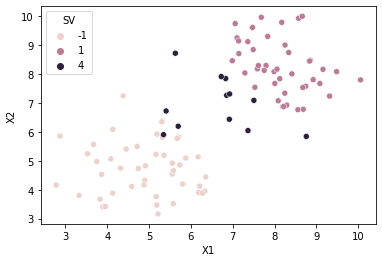

In [25]:
#color/hue of support vectors is
sv_hue = 4 #some value other than -1, +1 used for class labels
svecs = [y if ai == 0 else sv_hue for ai, y in zip(a_m, df['Y'].to_list())]
df['SV'] = svecs

#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[0], y=cols[1], hue='SV', data=df)

## Prediction

### Generate Data
Gaussian clusters in 2D numpy arrays

In [26]:
X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale) #generate test data points

### Predict

In [27]:
Y_pred = [fx(X_m[i], sv_X_m, sv_Y, sv_a_m, b_val) for i in range(M)] #predict (margin of) testing data
Y_pred_class = [-1 if y < 0 else 1 for y in Y_pred] #decision based on predicted margin

### Predicted X_m, Y in DataFrame

In [28]:
df = create_df_from_array(X_m, Y, n_features, cols) #create test dataframe
df['Y_pred_margin'] = Y_pred #append the prediction margin column
df['Y_pred_class'] = Y_pred_class #append the class
df.sample(n = 10)

,X1,X2,Y,Y_pred_margin,Y_pred_class
59,7.878629,8.481838,1,2.833952,1
20,5.884862,4.078395,-1,-2.751176,-1
68,9.831908,10.121277,1,5.895153,1
57,7.449198,7.206902,1,1.336733,1
81,6.443595,6.870737,1,0.218461,1
24,4.582161,4.861206,-1,-3.101826,-1
65,7.291804,8.876164,1,2.713573,1
1,5.773598,6.060365,-1,-1.055102,-1
8,3.778248,4.542449,-1,-4.040887,-1
51,8.768240,8.190470,1,3.292608,1


<AxesSubplot:xlabel='X1', ylabel='X2'>

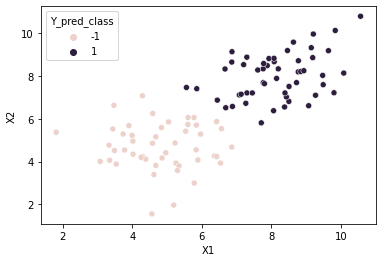

In [29]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[0], y=cols[1], hue='Y_pred_class', data=df)

### <font color=magenta>Prediction Accuracy</font>

In [30]:
Y_pred_corr = (Y==Y_pred_class)
num_corr = len(Y_pred_corr[Y_pred_corr == True])
print('Accuracy:', (num_corr/M)*100, '%')

Accuracy: 98.0 %


## Sidebar - <font color=blue>Primal to Dual Problem</font>

### Converting <font color=red>non-convex</font> primal problem to <font color=orange>convex</font> dual problem with <font color=orange>affine constraints</font>, and then to convex dual problem with <font color=green>no constraints</font> using <font color=magenta>Lagrange Multipliers</font>.

Refer CS229 notes while understanding my notes below.
- Stanford CS229 Course Notes on SVM
    * URL: http://cs229.stanford.edu/summer2020/cs229-notes3.pdf

### Functional Margin

- <font color=magenta>10-315 CMU Qatar</font> - Fall 2019 - Introduction to Machine Learning
    * https://web2.qatar.cmu.edu/~gdicaro/10315/lectures/315-F19-14-SVM-1.pdf
<img src="../assets/images/cs229-my-svm-notes-images/func_margin.png">

<img src="../assets/images/cs229-my-svm-notes-images/0001.jpg">

### Geometric Margin

<img src="../assets/images/cs229-my-svm-notes-images/geom_margin.png">

<img src="../assets/images/cs229-my-svm-notes-images/0002.jpg">

### Optimization Problem

<img src="../assets/images/cs229-my-svm-notes-images/0003.jpg">

### Lagrangian Duality

<img src="../assets/images/cs229-my-svm-notes-images/0004.jpg">

### Optimal Margin Classifiers

<img src="../assets/images/cs229-my-svm-notes-images/0005.jpg">

### Kernels

<img src="../assets/images/cs229-my-svm-notes-images/0006.jpg">

### Regularization, and SMO

<img src="../assets/images/cs229-my-svm-notes-images/0007.jpg">